Topic:        Challenge Set 1

Subject:      Explore MTA turnstile data

Date:         10/01/2018

Name:         Gretta Ferguson

In [177]:
import pandas as pd
import seaborn
import requests
import matplotlib.pyplot as plt
import datetime

# line magic
%pylab inline 

%matplotlib inline

%config InlineBackend.figure_format = 'svg'


Populating the interactive namespace from numpy and matplotlib


### 1.1 Download data and display columns

In [151]:
# Download data

df1 = pd.read_csv('turnstile_180922.csv')
df2 = pd.read_csv('turnstile_180915.csv')
df3 = pd.read_csv('turnstile_180908.csv')

df = pd.concat([df1,df2,df3])

df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [152]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199102 entries, 0 to 199101
Data columns (total 11 columns):
C/A                                                                     199102 non-null object
UNIT                                                                    199102 non-null object
SCP                                                                     199102 non-null object
STATION                                                                 199102 non-null object
LINENAME                                                                199102 non-null object
DIVISION                                                                199102 non-null object
DATE                                                                    199102 non-null object
TIME                                                                    199102 non-null object
DESC                                                                    199102 non-null object
ENTRIES                           

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592752 entries, 0 to 195656
Data columns (total 11 columns):
C/A                                                                     592752 non-null object
UNIT                                                                    592752 non-null object
SCP                                                                     592752 non-null object
STATION                                                                 592752 non-null object
LINENAME                                                                592752 non-null object
DIVISION                                                                592752 non-null object
DATE                                                                    592752 non-null object
TIME                                                                    592752 non-null object
DESC                                                                    592752 non-null object
ENTRIES                           

In [154]:
# 592752 entries, 0 to 195656... we need to reset the index column
df.reset_index(inplace=True, drop=True)
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,00:00:00,REGULAR,6759219,2291425
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,04:00:00,REGULAR,6759234,2291429


In [155]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [156]:
# Need to fix space issue in "Exits" column name
df.columns=df.columns.str.strip()
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

### 1.2 turn this into a time series 

In [157]:
# Combine date and time fields into a string

df['DATETIME_STR']=df['DATE']+[' ']+df['TIME']

In [158]:
# convert it into a datetime object and drop the string

df['DATETIME']=pd.to_datetime(df['DATETIME_STR'],format="%m/%d/%Y %H:%M:%S")
df.drop('DATETIME_STR',axis=1,inplace=True)

### 1.3 Calculate to total daily entries for each turnstile.

In [159]:
# sort so sequential entries for individual turnstiles are adjacent

df.sort_values(by=['STATION','UNIT','C/A','SCP','DATETIME'], inplace=True)
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
427136,H007,R248,00-00-00,1 AV,L,BMT,09/01/2018,00:00:00,REGULAR,13889527,15588326,2018-09-01 00:00:00
427137,H007,R248,00-00-00,1 AV,L,BMT,09/01/2018,04:00:00,REGULAR,13889615,15588468,2018-09-01 04:00:00


In [160]:
# compute entries and exits per time period
# note: periods=-1 computes the difference between the value in a row and the value in the next row
df['ENTRY_DIFF'] = (df.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                           .diff(periods=-1)) * -1
df['EXIT_DIFF'] = (df.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                           .diff(periods=-1)) * -1
df.head(2)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFF,EXIT_DIFF
427136,H007,R248,00-00-00,1 AV,L,BMT,09/01/2018,00:00:00,REGULAR,13889527,15588326,2018-09-01 00:00:00,88.0,142.0
427137,H007,R248,00-00-00,1 AV,L,BMT,09/01/2018,04:00:00,REGULAR,13889615,15588468,2018-09-01 04:00:00,54.0,255.0


In [161]:
# but there are issues due to turnstiles resetting
df['ENTRY_DIFF'].min()

-15832628.0

In [162]:
# throw out data that seems fallacious
df = df[(df['ENTRY_DIFF'] >= 0)
                & (df['ENTRY_DIFF'] < 10000)
                & (df['EXIT_DIFF'] >= 0)
                & (df['EXIT_DIFF'] < 10000)]

In [163]:
# sum the daily entries and store the pd series
daily_series=df.groupby(['C/A', 'SCP', 'DATE'])['ENTRY_DIFF'].sum()
daily_series.head(2)

C/A   SCP       DATE      
A002  02-00-00  09/01/2018    711.0
                09/02/2018    530.0
Name: ENTRY_DIFF, dtype: float64

### 1.4 Plot the daily time series for a turnstile

In [164]:
# Create a series for a single turnstile (A002, 02-00-00) and sum across all hours for that day

one_turnstile_series = df[(df['C/A'] =='A002') & (df['SCP']=='02-00-00')]
one_turnstile_daily_series=one_turnstile_series.groupby(['C/A', 'SCP', 'DATE'])['ENTRY_DIFF'].sum()

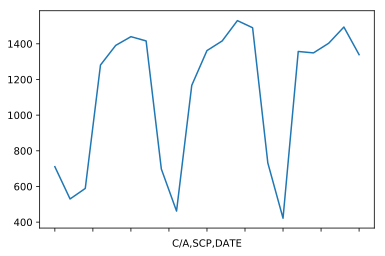

In [165]:
# Plot data

one_turnstile_daily_series.plot()
plt.show()

### 1.5 combine turnstiles in the same ControlArea/Unit/Station (across SCPs)

In [166]:
# sum the daily entries and store the pd series
daily_combo=df.groupby(['C/A', 'UNIT', 'STATION', 'DATE'])['ENTRY_DIFF'].sum()
daily_combo.head(2)

C/A   UNIT  STATION  DATE      
A002  R051  59 ST    09/01/2018    7619.0
                     09/02/2018    6061.0
Name: ENTRY_DIFF, dtype: float64

### 1.6 combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station

In [194]:
# sum the daily entries and store the pd series
daily_station=df.groupby(['STATION', 'DATE'])['ENTRY_DIFF'].sum()
daily_station.head(2)

STATION  DATE      
1 AV     09/01/2018    14045.0
         09/02/2018    11843.0
Name: ENTRY_DIFF, dtype: float64

### 1.7 Plot the time series (either daily or your preferred level of granularity) for a station

In [195]:
# Create a series for a single station (1 AV) and sum across all hours for that day

daily_one_station = df[(df['STATION'] =='1 AV')]
daily_one_station=daily_one_station.groupby(['STATION', 'DATE'])['ENTRY_DIFF'].sum()

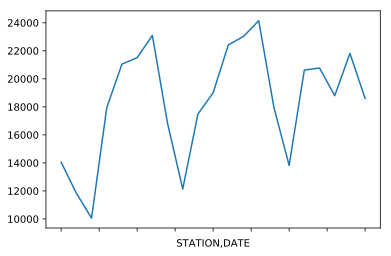

In [196]:
# Plot data

daily_one_station.plot()
plt.show()

### 1.8 Select a station and find the total daily counts for this station. Then plot those daily counts for each week separately.

In [211]:
daily_one_station_df=daily_one_station.to_frame()
#daily_one_station_df['DAY']=daily_one_station_df['DATETIME'].weekday()
daily_one_station_df.head()

ENTRY_DIFF
STATION DATE                  
1 AV    09/01/2018     14045.0
        09/02/2018     11843.0
        09/03/2018     10059.0
        09/04/2018     17936.0
        09/05/2018     21049.0

In [212]:
# add () at end for functional things like reset_index
# no () for non callable (non-doable) things like .columns. i.e. for attributes

daily_one_station_df_reset=daily_one_station_df.reset_index()
daily_one_station_df_reset.columns

Index(['STATION', 'DATE', 'ENTRY_DIFF'], dtype='object')

In [215]:
daily_one_station_df_reset['DAY']=pd.to_datetime(daily_one_station_df_reset['DATE']).dt.weekday
daily_one_station_df_reset.head(10)

,STATION,DATE,ENTRY_DIFF,DAY
0,1 AV,09/01/2018,14045.0,5
1,1 AV,09/02/2018,11843.0,6
2,1 AV,09/03/2018,10059.0,0
3,1 AV,09/04/2018,17936.0,1
4,1 AV,09/05/2018,21049.0,2
5,1 AV,09/06/2018,21510.0,3
6,1 AV,09/07/2018,23096.0,4
7,1 AV,09/08/2018,16827.0,5
8,1 AV,09/09/2018,12135.0,6
9,1 AV,09/10/2018,17488.0,0


In [241]:
pd.to_datetime(daily_one_station_df_reset['DATE'][0]).isocalendar()[1]

35

In [245]:
daily_one_station_df_reset['Week']=pd.to_datetime(daily_one_station_df_reset['DATE']).dt.week
daily_one_station_df_reset.head(10)

,STATION,DATE,ENTRY_DIFF,DAY,Week
0,1 AV,09/01/2018,14045.0,5,35
1,1 AV,09/02/2018,11843.0,6,35
2,1 AV,09/03/2018,10059.0,0,36
3,1 AV,09/04/2018,17936.0,1,36
4,1 AV,09/05/2018,21049.0,2,36
5,1 AV,09/06/2018,21510.0,3,36
6,1 AV,09/07/2018,23096.0,4,36
7,1 AV,09/08/2018,16827.0,5,36
8,1 AV,09/09/2018,12135.0,6,36
9,1 AV,09/10/2018,17488.0,0,37


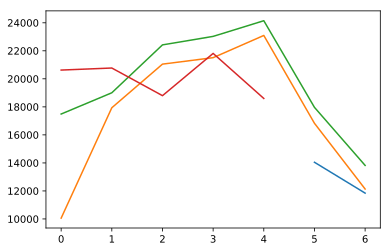

In [252]:
week35=daily_one_station_df_reset[(daily_one_station_df_reset['Week'] == 35)]
week36=daily_one_station_df_reset[(daily_one_station_df_reset['Week'] == 36)]
week37=daily_one_station_df_reset[(daily_one_station_df_reset['Week'] == 37)]
week38=daily_one_station_df_reset[(daily_one_station_df_reset['Week'] == 38)]

plt.plot('DAY','ENTRY_DIFF', data=week35)
plt.plot('DAY','ENTRY_DIFF', data=week36)
plt.plot('DAY','ENTRY_DIFF', data=week37)
plt.plot('DAY','ENTRY_DIFF', data=week38)
plt.show()

### 1.9 Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [259]:
station_3wk_total=df.groupby(['STATION'])['ENTRY_DIFF'].sum().sort_values(ascending=False)
station_3wk_total.head(10)

STATION
34 ST-PENN STA     2892404.0
GRD CNTRL-42 ST    2505537.0
34 ST-HERALD SQ    1890995.0
14 ST-UNION SQ     1883574.0
TIMES SQ-42 ST     1813017.0
23 ST              1796407.0
FULTON ST          1728829.0
42 ST-PORT AUTH    1620658.0
125 ST             1385488.0
CANAL ST           1379484.0
Name: ENTRY_DIFF, dtype: float64

### 1.10 Make a single list of these total ridership values and plot it with plt.hist(total_ridership_counts) to get an idea about the distribution of total ridership among different stations.

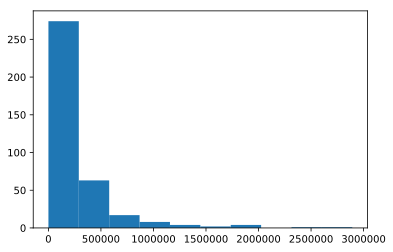

In [261]:
plt.hist(station_3wk_total);